In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import warnings
warnings.filterwarnings('ignore')

In [6]:
# Set display options
pd.set_option('display.max_columns', None)
plt.style.use('default')

In [7]:
#=============================================================================
# STEP 1: LOAD DATA
#=============================================================================
print("="*80)
print("STEP 1: LOADING DATA")
print("="*80)

# File paths
data_path = '/Users/davidscheider/anaconda_projects/ClimateWins/02 Data/Original Data/Dataset-weather-prediction-dataset-processed.csv'
pleasant_path = '/Users/davidscheider/anaconda_projects/ClimateWins/02 Data/Original Data/Dataset-Answers-Weather_Prediction_Pleasant_Weather.csv'

# Load datasets
df = pd.read_csv(data_path)
df_pleasant = pd.read_csv(pleasant_path)

print(f"Original data shape: {df.shape}")
print(f"Pleasant weather labels shape: {df_pleasant.shape}")


STEP 1: LOADING DATA
Original data shape: (22950, 170)
Pleasant weather labels shape: (22950, 16)


In [21]:
#=============================================================================
# STEP 2: FILTER DATA BY DECADE
#=============================================================================
print("\n" + "="*80)
print("STEP 2: FILTERING DATA BY DECADE")
print("="*80)

# Choose time period
# For 1980s: decade_filter = '198'
# For 1990s: decade_filter = '199'
# For single year 1985: decade_filter = '1985'
# For 2000s: decade_filter = '200'

decade_filter = '198'  # Change this to analyze different periods

# Filter data by converting DATE to string and checking if it starts with decade_filter
df['DATE_str'] = df['DATE'].astype(str)
df_filtered = df[df['DATE_str'].str.startswith(decade_filter)].copy()
df_pleasant_filtered = df_pleasant[df_pleasant['DATE'].astype(str).str.startswith(decade_filter)].copy()

print(f"\nFiltering for dates starting with '{decade_filter}'")
print(f"Filtered data shape: {df_filtered.shape}")
print(f"Date range: {df_filtered['DATE'].min()} to {df_filtered['DATE'].max()}")

# Verify we have matching rows
assert len(df_filtered) == len(df_pleasant_filtered), "Mismatch between data and labels!"


STEP 2: FILTERING DATA BY DECADE

Filtering for dates starting with '198'
Filtered data shape: (3653, 171)
Date range: 19800101 to 19891231


In [9]:
#=============================================================================
# STEP 3: PREPARE FEATURES (Remove DATE and MONTH columns)
#=============================================================================
print("\n" + "="*80)
print("STEP 3: PREPARING FEATURES")
print("="*80)

# Select only numeric weather features (exclude DATE, MONTH, DATE_str)
feature_cols = [col for col in df_filtered.columns if col not in ['DATE', 'MONTH', 'DATE_str']]
X = df_filtered[feature_cols].copy()

print(f"Number of features: {len(feature_cols)}")
print(f"Feature data shape: {X.shape}")
print(f"\nChecking for missing values: {X.isnull().sum().sum()} total missing values")

# Handle any missing values if present
if X.isnull().sum().sum() > 0:
    print("Filling missing values with column means...")
    X = X.fillna(X.mean())


STEP 3: PREPARING FEATURES
Number of features: 168
Feature data shape: (3653, 168)

Checking for missing values: 0 total missing values


In [10]:
#=============================================================================
# STEP 4: SCALE THE DATA
#=============================================================================
print("\n" + "="*80)
print("STEP 4: SCALING DATA")
print("="*80)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=feature_cols, index=X.index)

print("Data successfully scaled using StandardScaler")
print(f"Scaled data shape: {X_scaled_df.shape}")



STEP 4: SCALING DATA
Data successfully scaled using StandardScaler
Scaled data shape: (3653, 168)



STEP 5: CREATING DENDROGRAMS WITH ALL FOUR METHODS
This may take several minutes depending on data size...

Processing SINGLE method...
  Using UNSCALED data for single method (scaled may cause issues)
  ✓ SINGLE dendrogram created successfully

Processing COMPLETE method...
  ✓ COMPLETE dendrogram created successfully

Processing AVERAGE method...
  ✓ AVERAGE dendrogram created successfully

Processing WARD method...
  ✓ WARD dendrogram created successfully


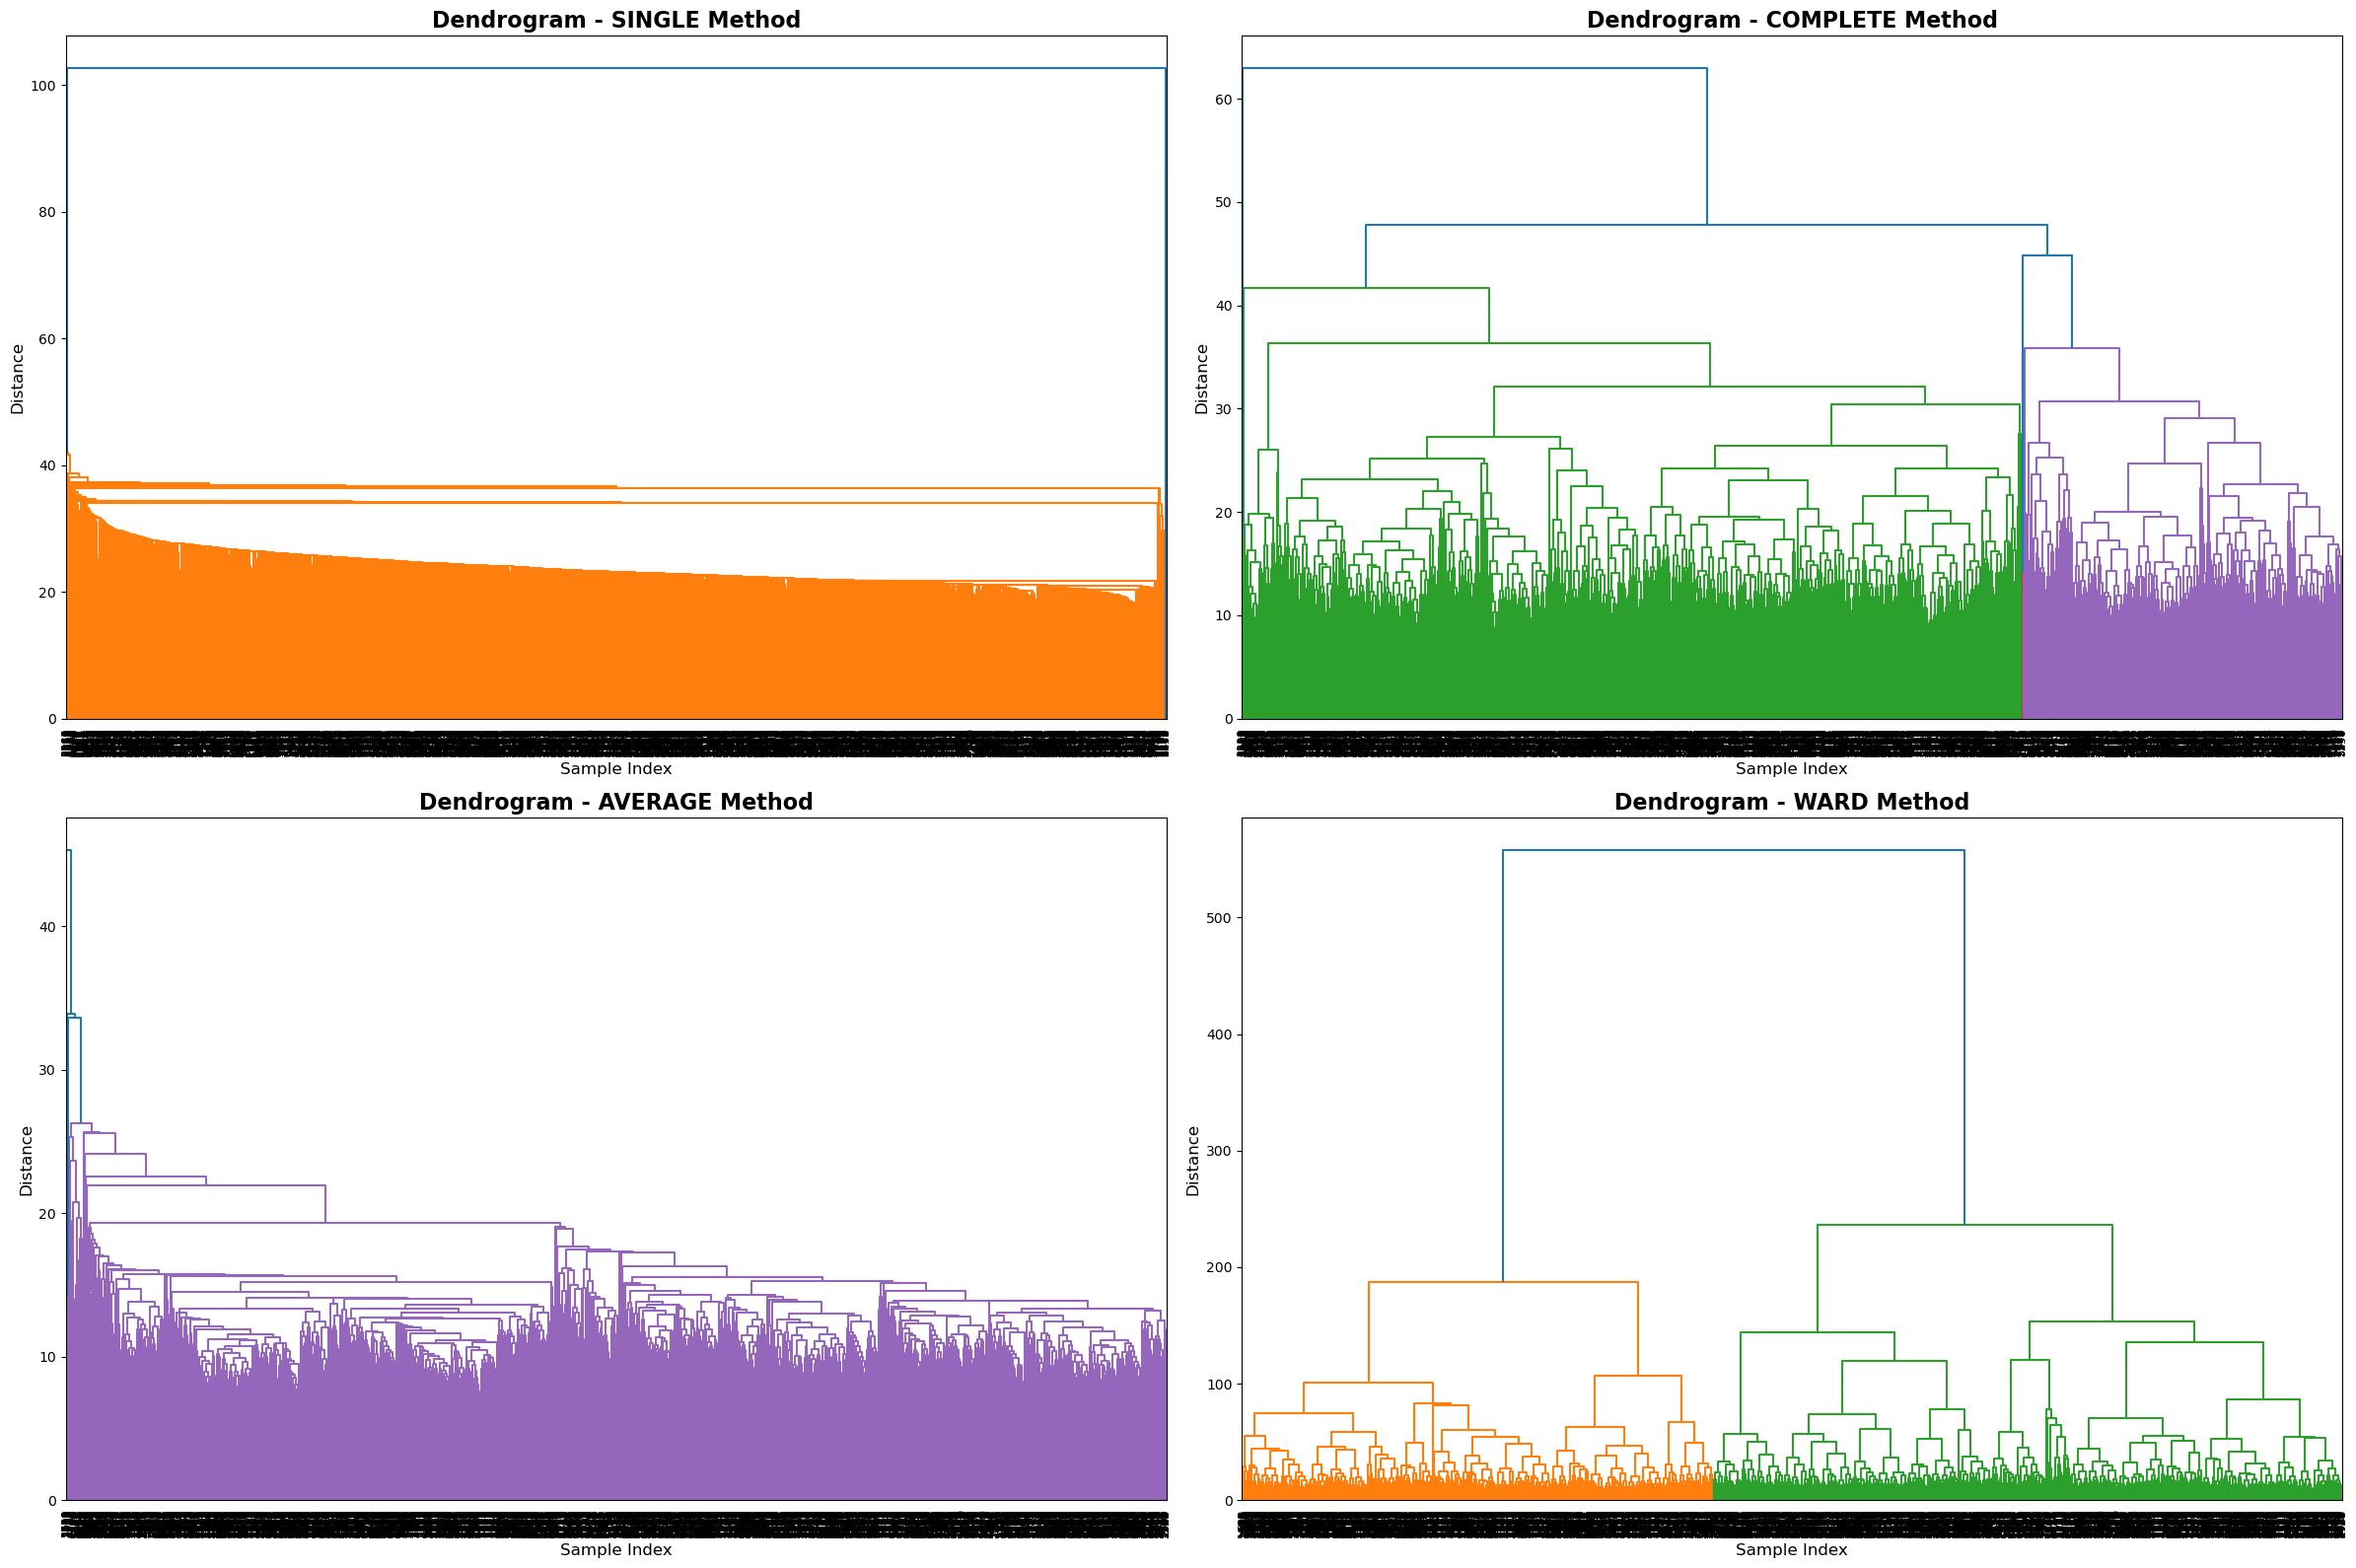


✓ All dendrograms saved as 'dendrograms_all_methods_{decade_filter}0s.png'


In [11]:
# =============================================================================
# STEP 5: HIERARCHICAL CLUSTERING - DENDROGRAMS
#=============================================================================
print("\n" + "="*80)
print("STEP 5: CREATING DENDROGRAMS WITH ALL FOUR METHODS")
print("="*80)
print("This may take several minutes depending on data size...")

methods = ['single', 'complete', 'average', 'ward']
linkage_results = {}

# Create figure with all four dendrograms
fig, axes = plt.subplots(2, 2, figsize=(24, 16))
axes = axes.ravel()

for idx, method in enumerate(methods):
    print(f"\nProcessing {method.upper()} method...")
    
    try:
        # Try with scaled data first
        if method == 'single':
            # Single method may crash with scaled data, so try unscaled first
            print("  Using UNSCALED data for single method (scaled may cause issues)")
            linkage_matrix = linkage(X, method=method)
        else:
            linkage_matrix = linkage(X_scaled, method=method)
        
        linkage_results[method] = linkage_matrix
        
        # Create dendrogram
        dendrogram(linkage_matrix, 
                  ax=axes[idx],
                  leaf_rotation=90,
                  leaf_font_size=8)
        
        axes[idx].set_title(f'Dendrogram - {method.upper()} Method', fontsize=16, fontweight='bold')
        axes[idx].set_xlabel('Sample Index', fontsize=12)
        axes[idx].set_ylabel('Distance', fontsize=12)
        
        print(f"  ✓ {method.upper()} dendrogram created successfully")
        
    except Exception as e:
        print(f"  ✗ Error with {method} method: {str(e)}")
        axes[idx].text(0.5, 0.5, f'Error with {method} method:\n{str(e)}', 
                      ha='center', va='center', transform=axes[idx].transAxes)

plt.tight_layout()
plt.savefig(f'dendrograms_all_methods_{decade_filter}0s.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ All dendrograms saved as 'dendrograms_all_methods_{decade_filter}0s.png'")

In [12]:
#=============================================================================
# STEP 6: ANALYZE CLUSTERS FOR EACH METHOD
#=============================================================================
print("\n" + "="*80)
print("STEP 6: CLUSTER ANALYSIS")
print("="*80)

# Test different numbers of clusters (k) for each method
k_values = [2, 3, 4, 5]

for method in methods:
    if method not in linkage_results:
        continue
        
    print(f"\n{method.upper()} Method Analysis:")
    print("-" * 40)
    
    for k in k_values:
        clusters = fcluster(linkage_results[method], k, criterion='maxclust')
        cluster_counts = pd.Series(clusters).value_counts().sort_index()
        print(f"  k={k}: Cluster sizes: {cluster_counts.values}")


STEP 6: CLUSTER ANALYSIS

SINGLE Method Analysis:
----------------------------------------
  k=2: Cluster sizes: [3651    2]
  k=3: Cluster sizes: [3651    1    1]
  k=4: Cluster sizes: [3650    1    1    1]
  k=5: Cluster sizes: [3649    1    1    1    1]

COMPLETE Method Analysis:
----------------------------------------
  k=2: Cluster sizes: [   2 3651]
  k=3: Cluster sizes: [   2 2590 1061]
  k=4: Cluster sizes: [   2 2590    2 1059]
  k=5: Cluster sizes: [   2    4 2586    2 1059]

AVERAGE Method Analysis:
----------------------------------------
  k=2: Cluster sizes: [   2 3651]
  k=3: Cluster sizes: [   2    2 3649]
  k=4: Cluster sizes: [   2    2    4 3645]
  k=5: Cluster sizes: [   2    2    4   50 3595]

WARD Method Analysis:
----------------------------------------
  k=2: Cluster sizes: [1565 2088]
  k=3: Cluster sizes: [1565  924 1164]
  k=4: Cluster sizes: [1026  539  924 1164]
  k=5: Cluster sizes: [1026  539  924  263  901]



STEP 7: COMPARING CLUSTERS WITH PLEASANT WEATHER LABELS


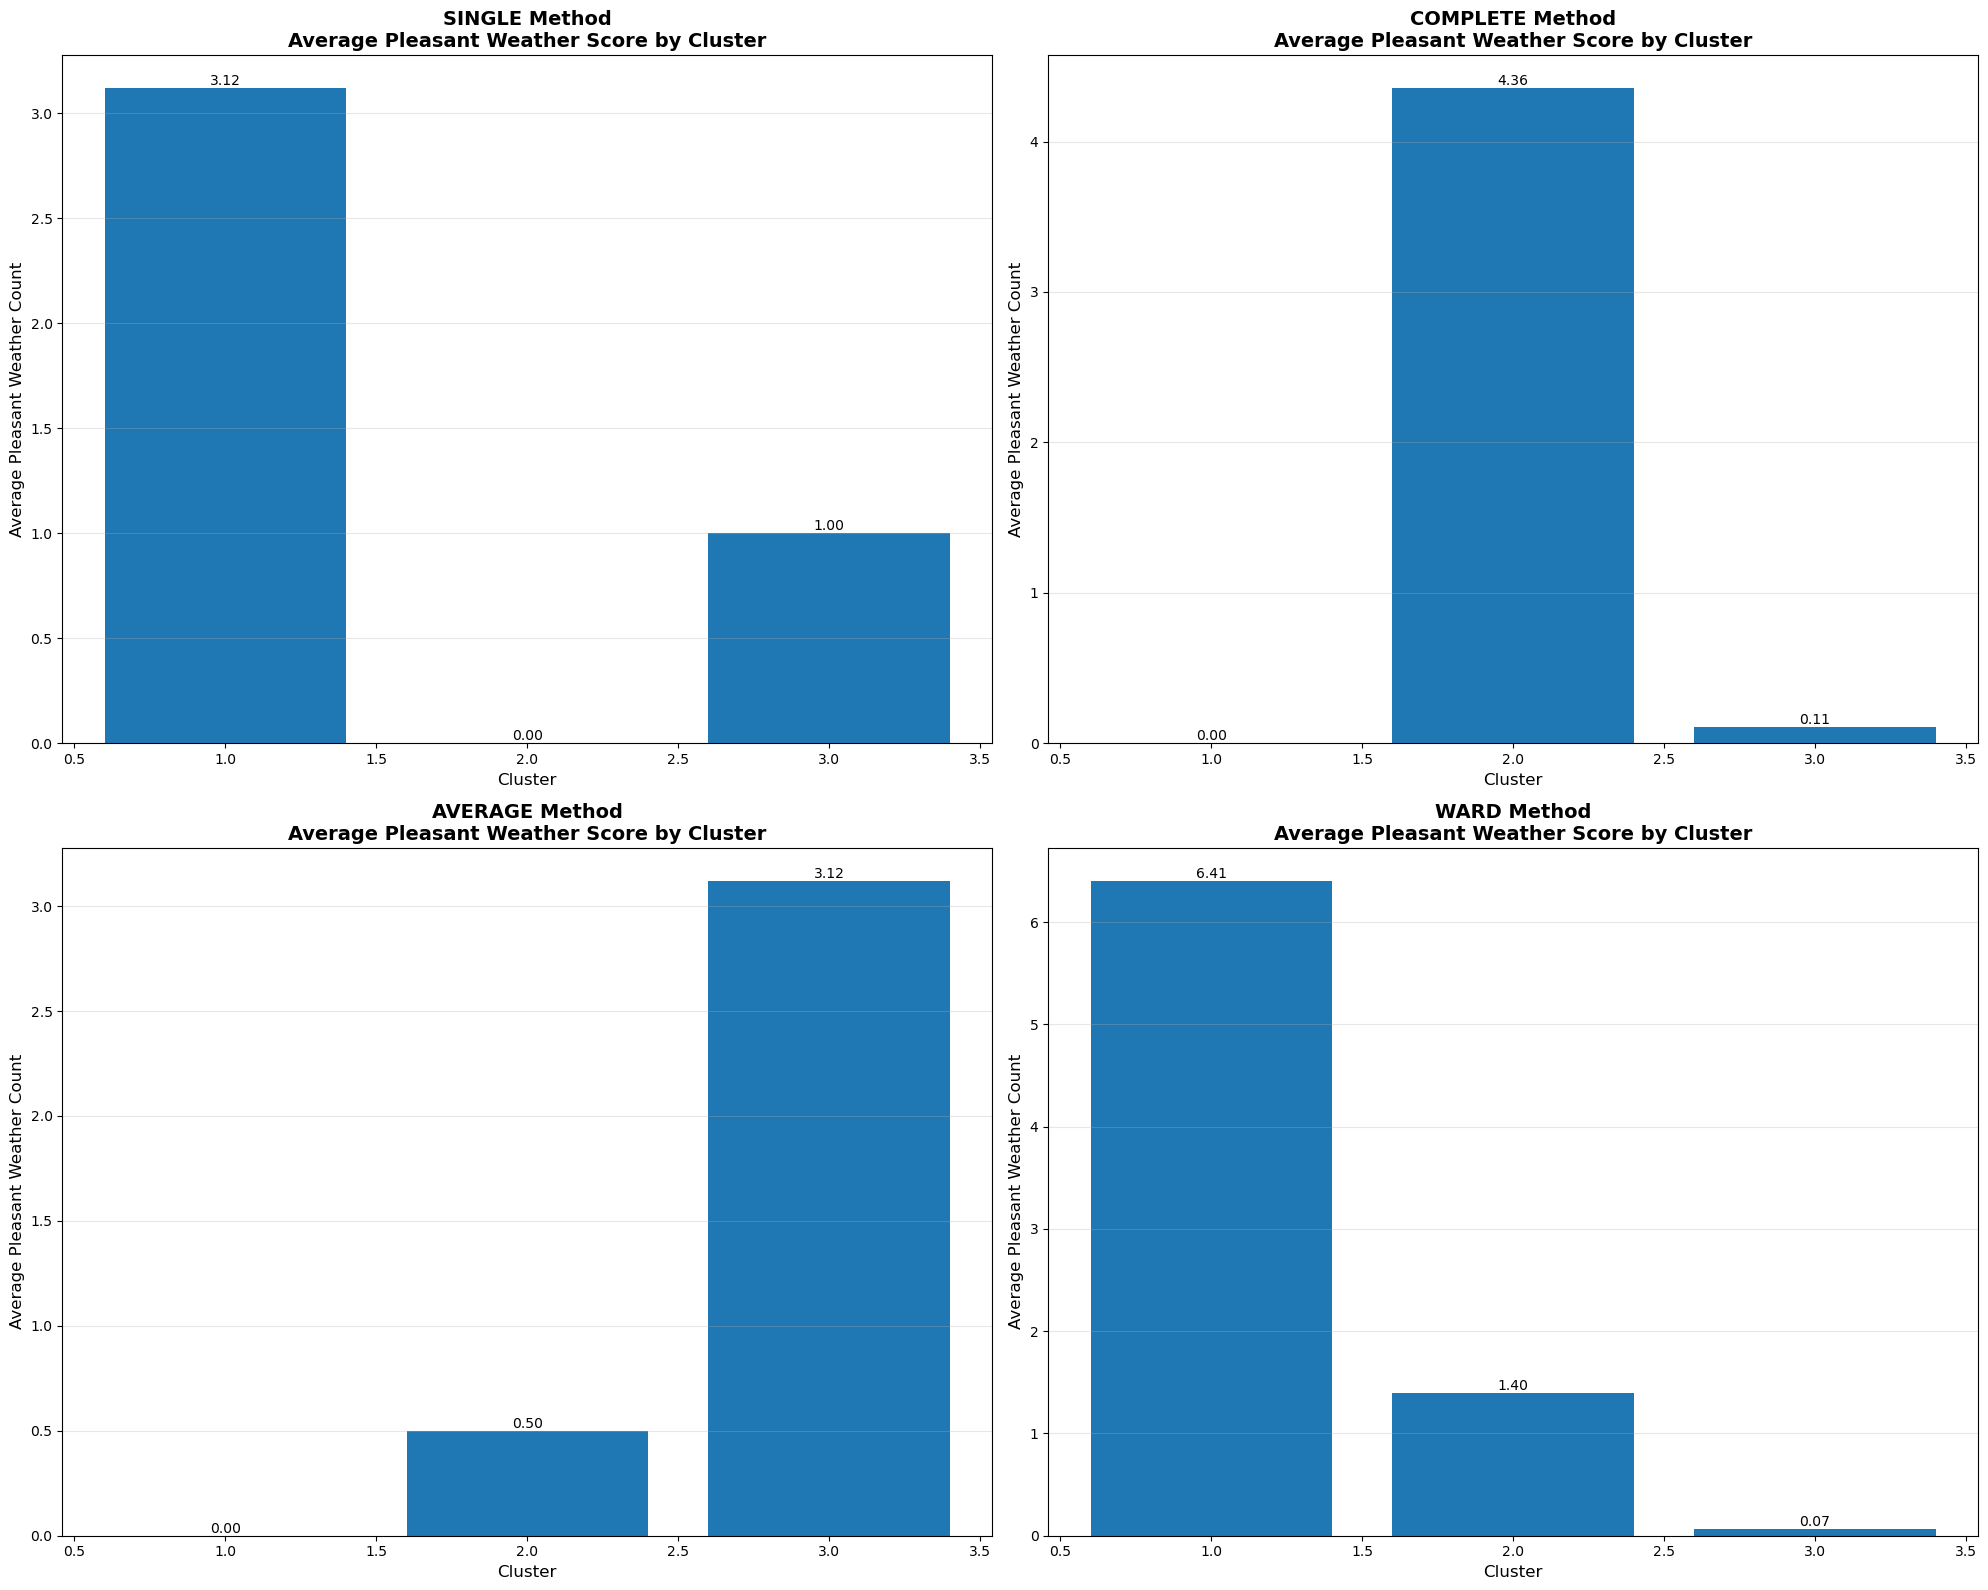


✓ Cluster comparison saved as 'cluster_pleasant_weather_comparison_1980s.png'


In [13]:
#=============================================================================
# STEP 7: COMPARE CLUSTERS WITH PLEASANT WEATHER LABELS
#=============================================================================
print("\n" + "="*80)
print("STEP 7: COMPARING CLUSTERS WITH PLEASANT WEATHER LABELS")
print("="*80)

# Create a comprehensive comparison for k=3 (adjust as needed)
k = 3

fig, axes = plt.subplots(2, 2, figsize=(20, 16))
axes = axes.ravel()

for idx, method in enumerate(methods):
    if method not in linkage_results:
        continue
    
    # Get cluster assignments
    clusters = fcluster(linkage_results[method], k, criterion='maxclust')
    
    # Add to dataframe
    df_analysis = df_filtered.copy()
    df_analysis['cluster'] = clusters
    
    # Merge with pleasant weather labels
    df_analysis = df_analysis.merge(df_pleasant_filtered, on='DATE', how='left')
    
    # Count pleasant weather days per cluster
    pleasant_cols = [col for col in df_pleasant_filtered.columns if col.endswith('_pleasant_weather')]
    df_analysis['total_pleasant'] = df_analysis[pleasant_cols].sum(axis=1)
    
    # Visualize
    cluster_pleasant = df_analysis.groupby('cluster')['total_pleasant'].agg(['mean', 'sum', 'count'])
    
    axes[idx].bar(cluster_pleasant.index, cluster_pleasant['mean'])
    axes[idx].set_title(f'{method.upper()} Method\nAverage Pleasant Weather Score by Cluster', 
                       fontsize=14, fontweight='bold')
    axes[idx].set_xlabel('Cluster', fontsize=12)
    axes[idx].set_ylabel('Average Pleasant Weather Count', fontsize=12)
    axes[idx].grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for i, v in enumerate(cluster_pleasant['mean']):
        axes[idx].text(i+1, v, f'{v:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.savefig(f'cluster_pleasant_weather_comparison_{decade_filter}0s.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Cluster comparison saved as 'cluster_pleasant_weather_comparison_{decade_filter}0s.png'")


STEP 8: PRINCIPAL COMPONENT ANALYSIS (PCA)

Testing different numbers of components...


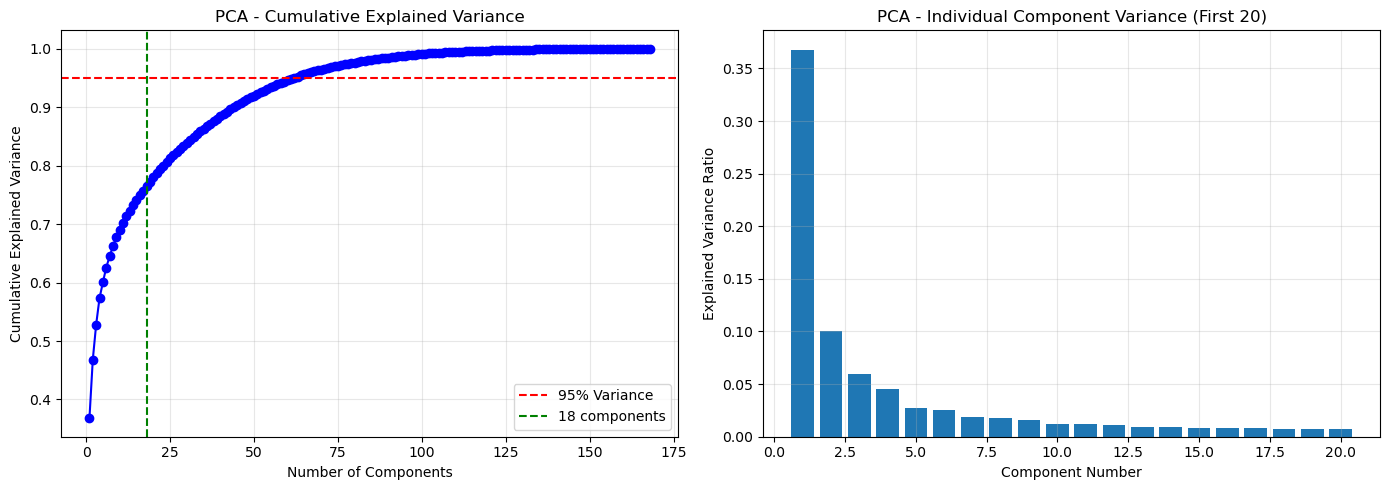


Components needed for 95% variance: 62
Components using number of stations: 18
Variance explained with 18 components: 76.49%

PCA transformation complete:
  Original dimensions: 168
  Reduced dimensions: 18
  Variance retained: 76.49%


In [14]:
#=============================================================================
# STEP 8: PRINCIPAL COMPONENT ANALYSIS (PCA)
#=============================================================================
print("\n" + "="*80)
print("STEP 8: PRINCIPAL COMPONENT ANALYSIS (PCA)")
print("="*80)

# Decide on number of components to reduce to
# Options: number of weather stations (18), or keep 95% variance
n_stations = 18  # Number of weather stations

print(f"\nTesting different numbers of components...")

# First, see how much variance is explained by different numbers of components
pca_full = PCA()
pca_full.fit(X_scaled)

# Plot explained variance
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(pca_full.explained_variance_ratio_) + 1), 
         np.cumsum(pca_full.explained_variance_ratio_), 'bo-')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance')
plt.axvline(x=n_stations, color='g', linestyle='--', label=f'{n_stations} components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA - Cumulative Explained Variance')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.bar(range(1, min(21, len(pca_full.explained_variance_ratio_) + 1)), 
        pca_full.explained_variance_ratio_[:20])
plt.xlabel('Component Number')
plt.ylabel('Explained Variance Ratio')
plt.title('PCA - Individual Component Variance (First 20)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'pca_variance_analysis_{decade_filter}0s.png', dpi=300, bbox_inches='tight')
plt.show()

# Find number of components for 95% variance
n_components_95 = np.argmax(np.cumsum(pca_full.explained_variance_ratio_) >= 0.95) + 1
print(f"\nComponents needed for 95% variance: {n_components_95}")
print(f"Components using number of stations: {n_stations}")
print(f"Variance explained with {n_stations} components: {np.cumsum(pca_full.explained_variance_ratio_)[n_stations-1]:.2%}")

# Apply PCA with selected number of components
n_components = n_stations  # You can change this to n_components_95 if preferred

pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)

print(f"\nPCA transformation complete:")
print(f"  Original dimensions: {X_scaled.shape[1]}")
print(f"  Reduced dimensions: {X_pca.shape[1]}")
print(f"  Variance retained: {sum(pca.explained_variance_ratio_):.2%}")

# Create DataFrame with reduced features
pca_columns = [f'PC{i+1}' for i in range(n_components)]
X_pca_df = pd.DataFrame(X_pca, columns=pca_columns, index=X.index)

In [15]:
#=============================================================================
# STEP 9: EXPORT REDUCED DATA
#=============================================================================
print("\n" + "="*80)
print("STEP 9: EXPORTING REDUCED DATASET")
print("="*80)

# Combine with DATE for reference
X_pca_export = X_pca_df.copy()
X_pca_export.insert(0, 'DATE', df_filtered['DATE'].values)

output_path = f'/Users/davidscheider/anaconda_projects/ClimateWins/02 Data/Original Data/weather_data_pca_reduced_{decade_filter}0s.csv'
X_pca_export.to_csv(output_path, index=False)

print(f"✓ Reduced dataset exported to: {output_path}")
print(f"  Shape: {X_pca_export.shape}")


STEP 9: EXPORTING REDUCED DATASET
✓ Reduced dataset exported to: /Users/davidscheider/anaconda_projects/ClimateWins/02 Data/Original Data/weather_data_pca_reduced_1980s.csv
  Shape: (3653, 19)



STEP 10: HIERARCHICAL CLUSTERING ON PCA-REDUCED DATA

Processing SINGLE method on PCA-reduced data...
  ✓ SINGLE dendrogram created successfully

Processing COMPLETE method on PCA-reduced data...
  ✓ COMPLETE dendrogram created successfully

Processing AVERAGE method on PCA-reduced data...
  ✓ AVERAGE dendrogram created successfully

Processing WARD method on PCA-reduced data...
  ✓ WARD dendrogram created successfully


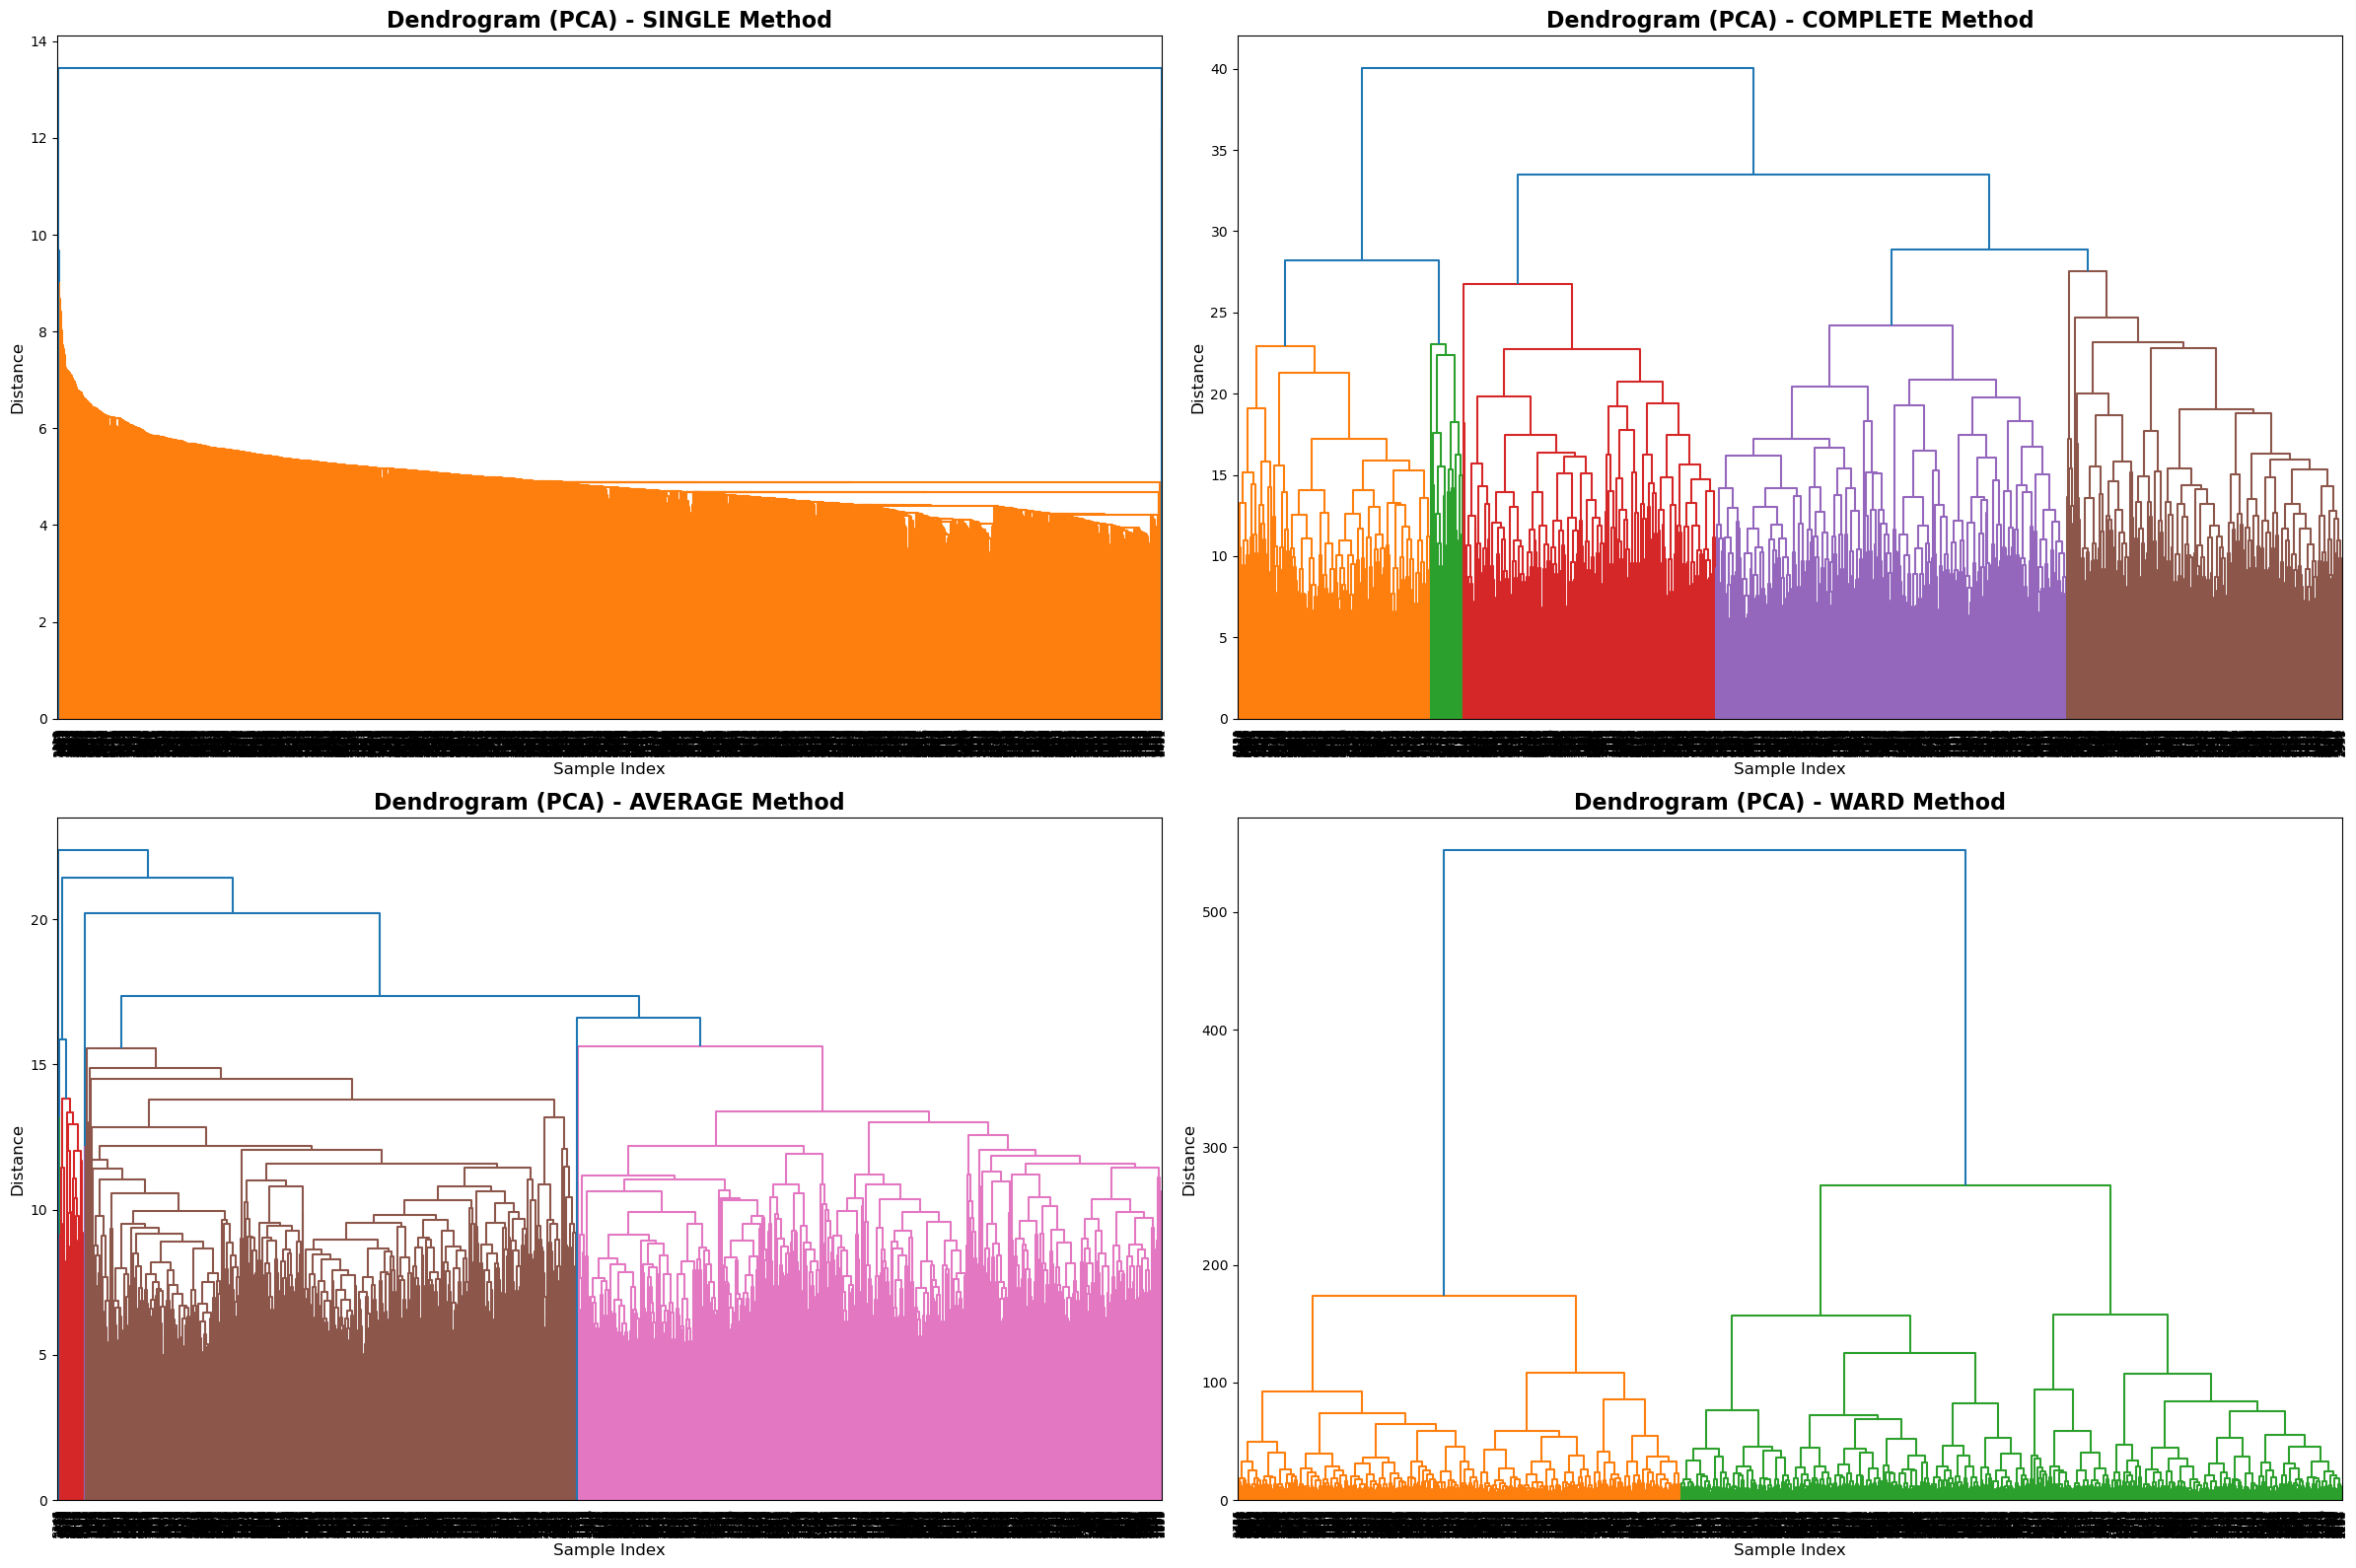


✓ PCA dendrograms saved as 'dendrograms_pca_all_methods_1980s.png'


In [16]:
#=============================================================================
# STEP 10: HIERARCHICAL CLUSTERING ON REDUCED DATA
#=============================================================================
print("\n" + "="*80)
print("STEP 10: HIERARCHICAL CLUSTERING ON PCA-REDUCED DATA")
print("="*80)

linkage_results_pca = {}

# Create figure with all four dendrograms for PCA data
fig, axes = plt.subplots(2, 2, figsize=(24, 16))
axes = axes.ravel()

for idx, method in enumerate(methods):
    print(f"\nProcessing {method.upper()} method on PCA-reduced data...")
    
    try:
        # PCA data is already scaled, so use it directly
        linkage_matrix = linkage(X_pca, method=method)
        linkage_results_pca[method] = linkage_matrix
        
        # Create dendrogram
        dendrogram(linkage_matrix, 
                  ax=axes[idx],
                  leaf_rotation=90,
                  leaf_font_size=8)
        
        axes[idx].set_title(f'Dendrogram (PCA) - {method.upper()} Method', fontsize=16, fontweight='bold')
        axes[idx].set_xlabel('Sample Index', fontsize=12)
        axes[idx].set_ylabel('Distance', fontsize=12)
        
        print(f"  ✓ {method.upper()} dendrogram created successfully")
        
    except Exception as e:
        print(f"  ✗ Error with {method} method: {str(e)}")
        axes[idx].text(0.5, 0.5, f'Error with {method} method:\n{str(e)}', 
                      ha='center', va='center', transform=axes[idx].transAxes)

plt.tight_layout()
plt.savefig(f'dendrograms_pca_all_methods_{decade_filter}0s.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ PCA dendrograms saved as 'dendrograms_pca_all_methods_{decade_filter}0s.png'")


STEP 11: COMPARING PCA CLUSTERS WITH PLEASANT WEATHER LABELS


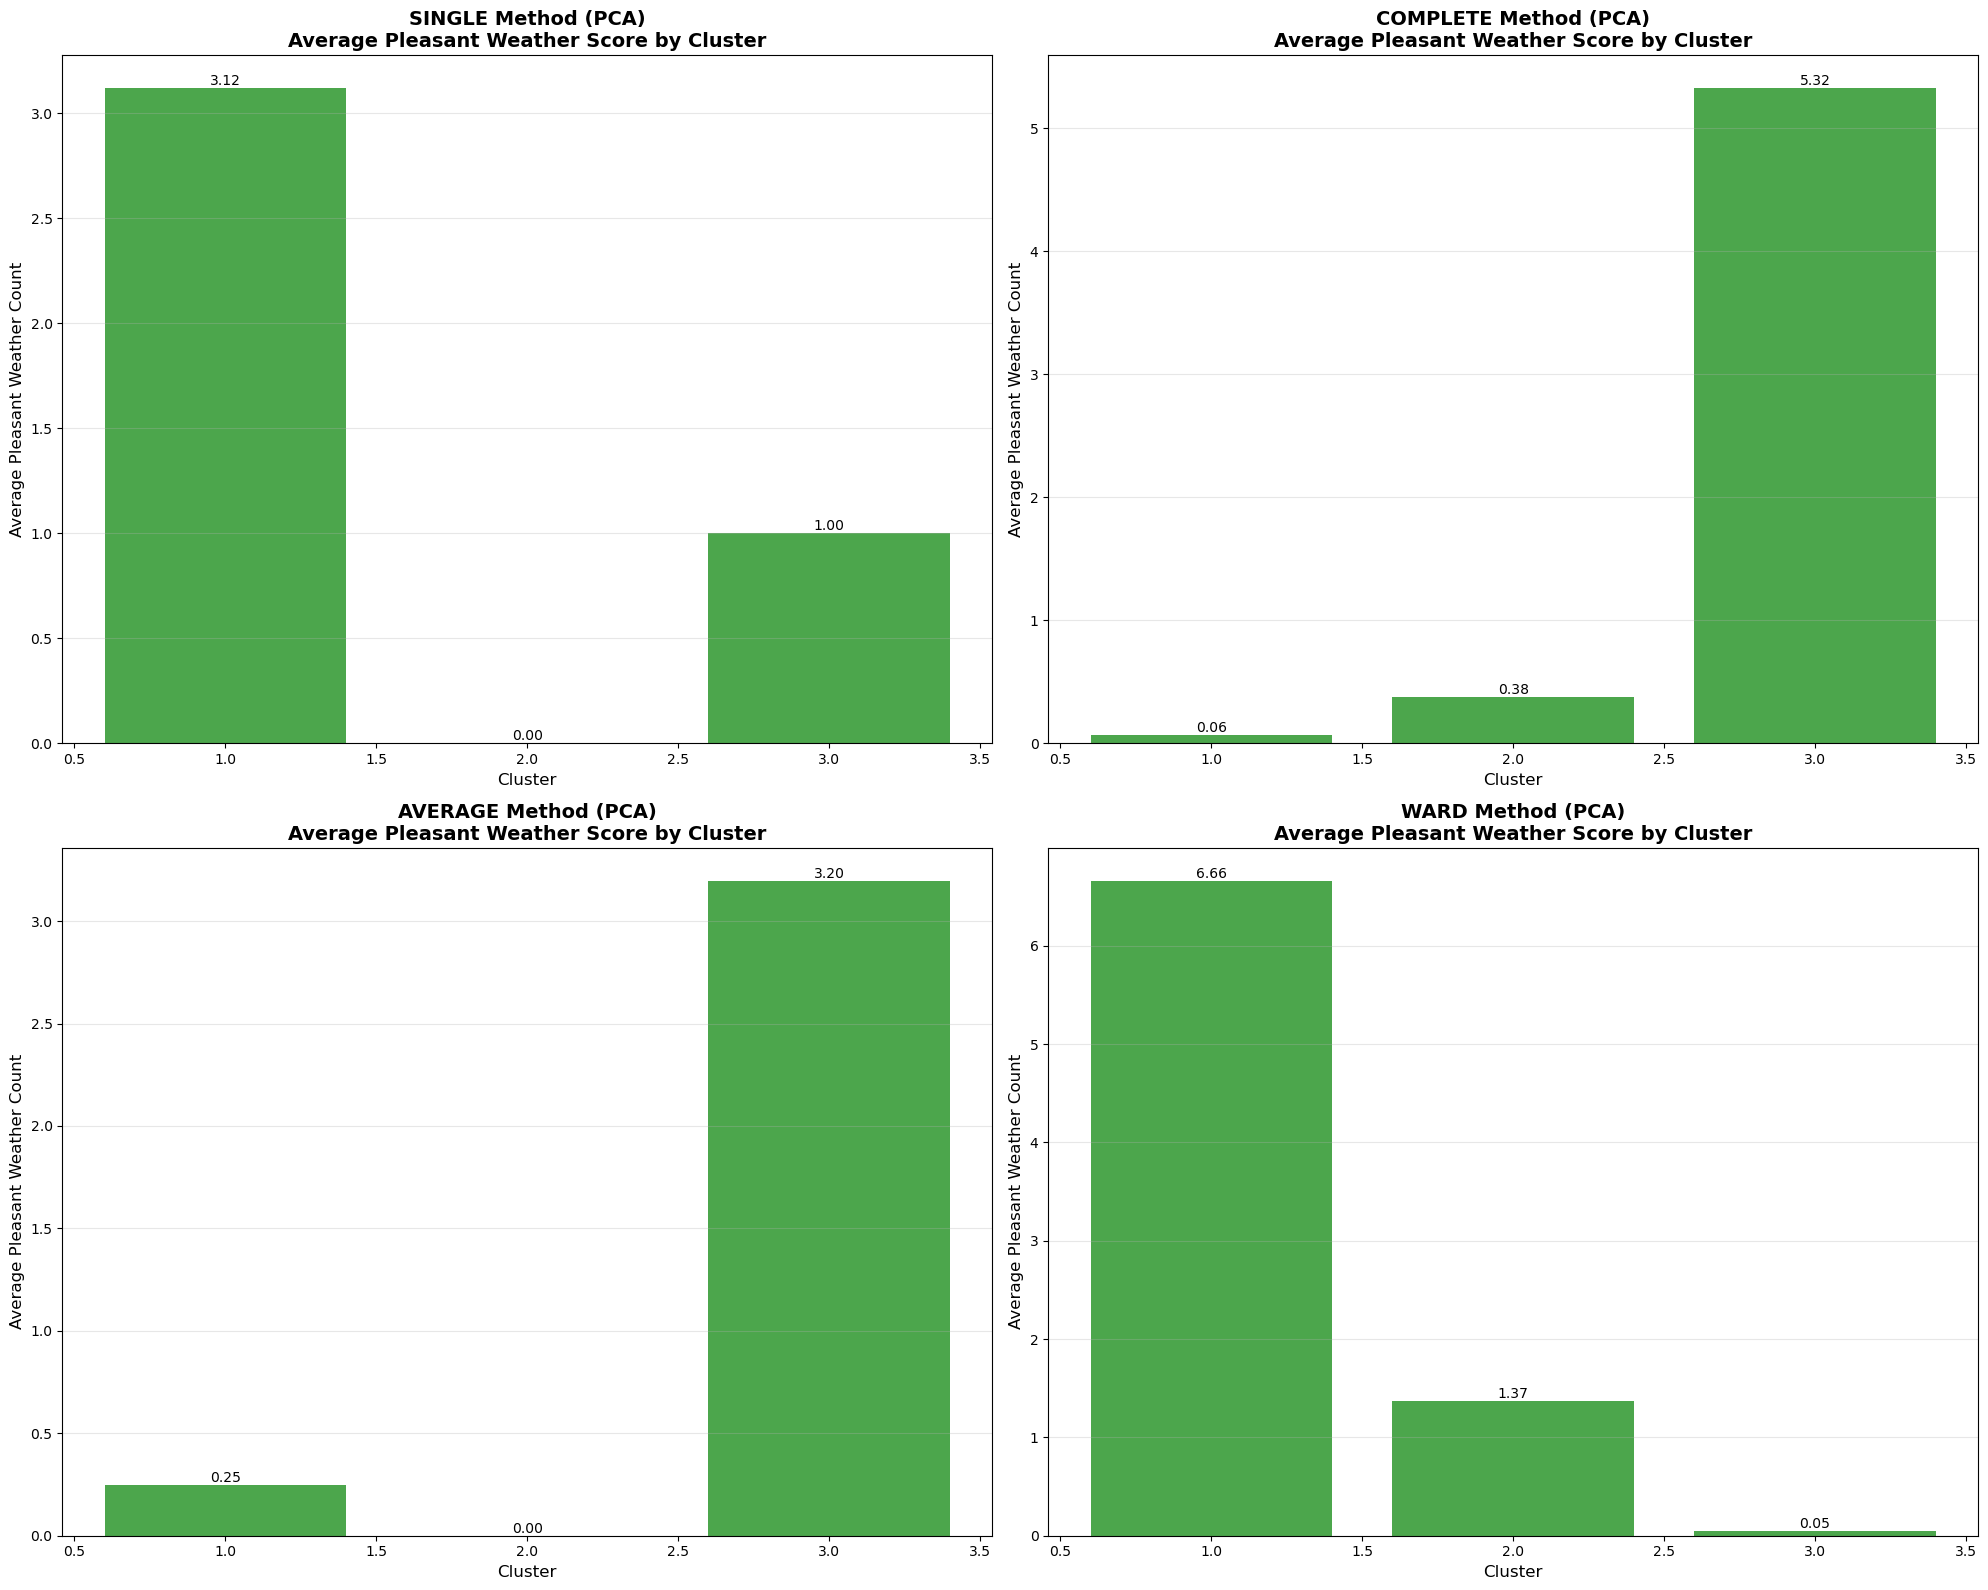


✓ PCA cluster comparison saved as 'cluster_pca_pleasant_weather_comparison_1980s.png'


In [17]:
#=============================================================================
# STEP 11: COMPARE PCA CLUSTERS WITH PLEASANT WEATHER
#=============================================================================
print("\n" + "="*80)
print("STEP 11: COMPARING PCA CLUSTERS WITH PLEASANT WEATHER LABELS")
print("="*80)

fig, axes = plt.subplots(2, 2, figsize=(20, 16))
axes = axes.ravel()

for idx, method in enumerate(methods):
    if method not in linkage_results_pca:
        continue
    
    # Get cluster assignments
    clusters = fcluster(linkage_results_pca[method], k, criterion='maxclust')
    
    # Add to dataframe
    df_analysis_pca = df_filtered.copy()
    df_analysis_pca['cluster_pca'] = clusters
    
    # Merge with pleasant weather labels
    df_analysis_pca = df_analysis_pca.merge(df_pleasant_filtered, on='DATE', how='left')
    
    # Count pleasant weather days per cluster
    pleasant_cols = [col for col in df_pleasant_filtered.columns if col.endswith('_pleasant_weather')]
    df_analysis_pca['total_pleasant'] = df_analysis_pca[pleasant_cols].sum(axis=1)
    
    # Visualize
    cluster_pleasant = df_analysis_pca.groupby('cluster_pca')['total_pleasant'].agg(['mean', 'sum', 'count'])
    
    axes[idx].bar(cluster_pleasant.index, cluster_pleasant['mean'], color='green', alpha=0.7)
    axes[idx].set_title(f'{method.upper()} Method (PCA)\nAverage Pleasant Weather Score by Cluster', 
                       fontsize=14, fontweight='bold')
    axes[idx].set_xlabel('Cluster', fontsize=12)
    axes[idx].set_ylabel('Average Pleasant Weather Count', fontsize=12)
    axes[idx].grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for i, v in enumerate(cluster_pleasant['mean']):
        axes[idx].text(i+1, v, f'{v:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.savefig(f'cluster_pca_pleasant_weather_comparison_{decade_filter}0s.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ PCA cluster comparison saved as 'cluster_pca_pleasant_weather_comparison_{decade_filter}0s.png'")


STEP 12: SIDE-BY-SIDE COMPARISON - ORIGINAL VS PCA


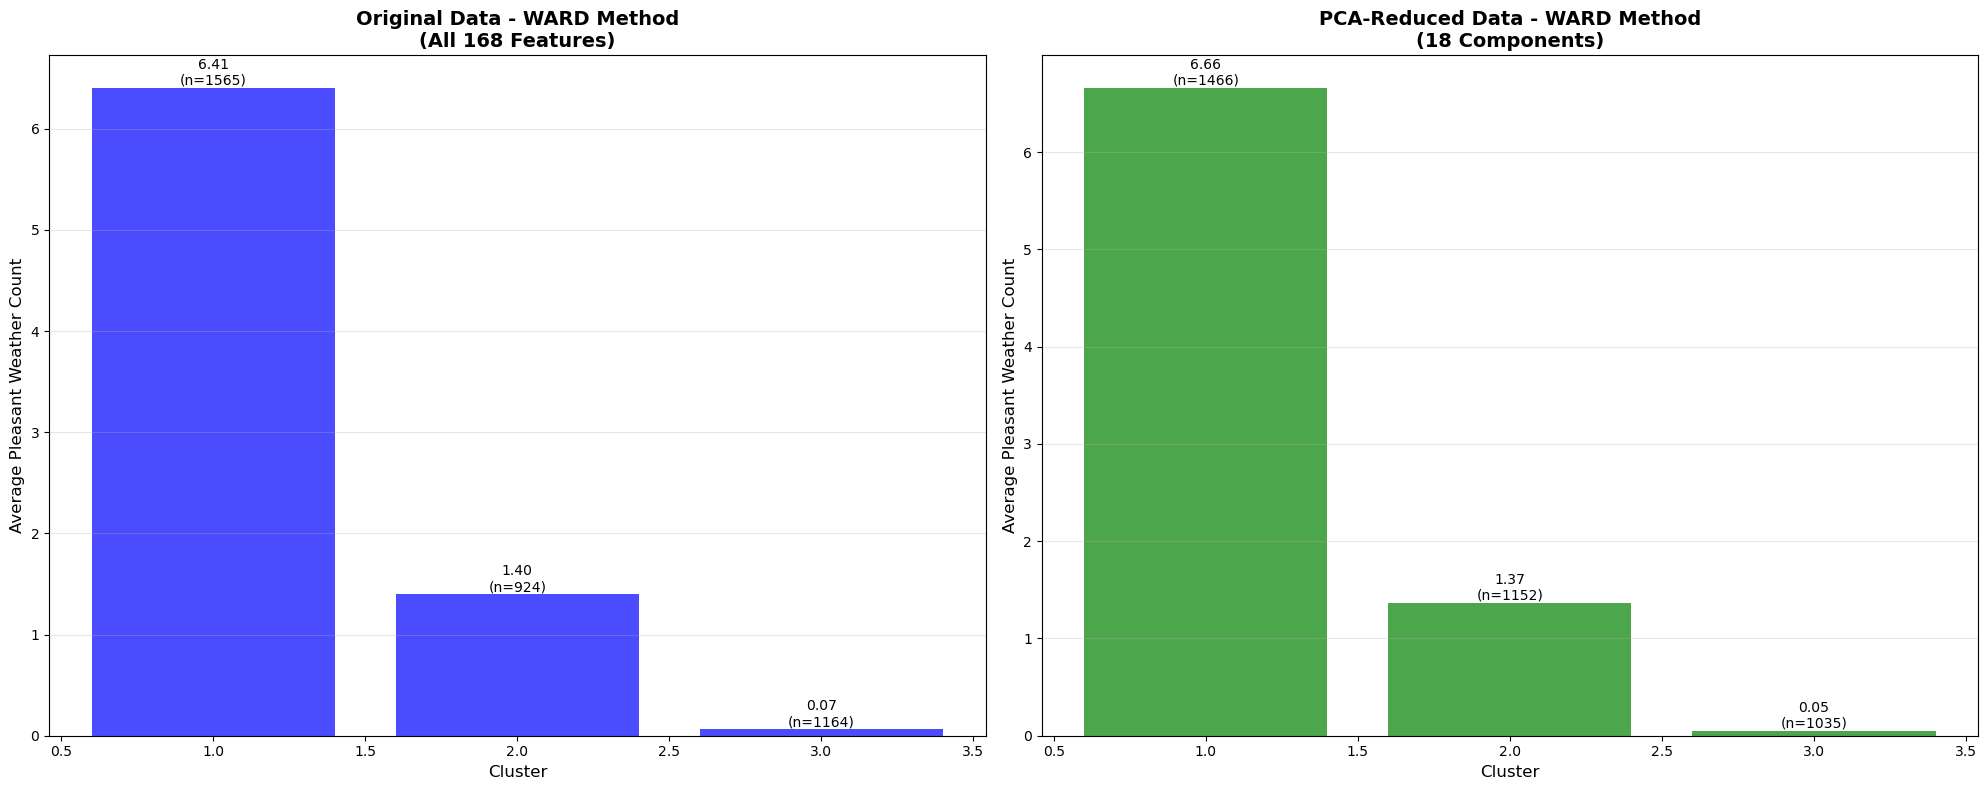


✓ Comparison saved as 'comparison_original_vs_pca_1980s.png'


In [18]:
#=============================================================================
# STEP 12: FINAL COMPARISON - ORIGINAL VS PCA CLUSTERING
#=============================================================================
print("\n" + "="*80)
print("STEP 12: SIDE-BY-SIDE COMPARISON - ORIGINAL VS PCA")
print("="*80)

# Create comprehensive comparison for Ward method (typically performs best)
method = 'ward'

if method in linkage_results and method in linkage_results_pca:
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    
    # Original data clustering
    clusters_orig = fcluster(linkage_results[method], k, criterion='maxclust')
    df_comp = df_filtered.copy()
    df_comp['cluster_original'] = clusters_orig
    df_comp = df_comp.merge(df_pleasant_filtered, on='DATE', how='left')
    pleasant_cols = [col for col in df_pleasant_filtered.columns if col.endswith('_pleasant_weather')]
    df_comp['total_pleasant'] = df_comp[pleasant_cols].sum(axis=1)
    
    cluster_stats_orig = df_comp.groupby('cluster_original')['total_pleasant'].agg(['mean', 'count'])
    
    axes[0].bar(cluster_stats_orig.index, cluster_stats_orig['mean'], color='blue', alpha=0.7)
    axes[0].set_title(f'Original Data - {method.upper()} Method\n(All {X.shape[1]} Features)', 
                     fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Cluster', fontsize=12)
    axes[0].set_ylabel('Average Pleasant Weather Count', fontsize=12)
    axes[0].grid(axis='y', alpha=0.3)
    
    for i, v in enumerate(cluster_stats_orig['mean']):
        axes[0].text(i+1, v, f'{v:.2f}\n(n={cluster_stats_orig["count"].iloc[i]})', 
                    ha='center', va='bottom')
    
    # PCA data clustering
    clusters_pca = fcluster(linkage_results_pca[method], k, criterion='maxclust')
    df_comp['cluster_pca'] = clusters_pca
    
    cluster_stats_pca = df_comp.groupby('cluster_pca')['total_pleasant'].agg(['mean', 'count'])
    
    axes[1].bar(cluster_stats_pca.index, cluster_stats_pca['mean'], color='green', alpha=0.7)
    axes[1].set_title(f'PCA-Reduced Data - {method.upper()} Method\n({n_components} Components)', 
                     fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Cluster', fontsize=12)
    axes[1].set_ylabel('Average Pleasant Weather Count', fontsize=12)
    axes[1].grid(axis='y', alpha=0.3)
    
    for i, v in enumerate(cluster_stats_pca['mean']):
        axes[1].text(i+1, v, f'{v:.2f}\n(n={cluster_stats_pca["count"].iloc[i]})', 
                    ha='center', va='bottom')
    
    plt.tight_layout()
    plt.savefig(f'comparison_original_vs_pca_{decade_filter}0s.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\n✓ Comparison saved as 'comparison_original_vs_pca_{decade_filter}0s.png'")

In [19]:
#=============================================================================
# STEP 13: SUMMARY STATISTICS
#=============================================================================
print("\n" + "="*80)
print("SUMMARY STATISTICS AND INSIGHTS")
print("="*80)

print(f"\nDataset: {decade_filter}0s Weather Data")
print(f"Total days analyzed: {len(df_filtered)}")
print(f"Original features: {X.shape[1]}")
print(f"PCA components: {n_components}")
print(f"Variance retained: {sum(pca.explained_variance_ratio_):.2%}")

print("\n" + "-"*80)
print("CLUSTERING RESULTS SUMMARY")
print("-"*80)

for method in methods:
    if method in linkage_results:
        clusters = fcluster(linkage_results[method], 3, criterion='maxclust')
        print(f"\n{method.upper()} Method (Original Data):")
        print(f"  Cluster distribution: {pd.Series(clusters).value_counts().sort_index().to_dict()}")

print("\n" + "-"*80)

for method in methods:
    if method in linkage_results_pca:
        clusters = fcluster(linkage_results_pca[method], 3, criterion='maxclust')
        print(f"\n{method.upper()} Method (PCA Data):")
        print(f"  Cluster distribution: {pd.Series(clusters).value_counts().sort_index().to_dict()}")

print("\n" + "="*80)
print("ANALYSIS COMPLETE!")
print("="*80)
print("\nGenerated files:")
print(f"  1. dendrograms_all_methods_{decade_filter}0s.png")
print(f"  2. cluster_pleasant_weather_comparison_{decade_filter}0s.png")
print(f"  3. pca_variance_analysis_{decade_filter}0s.png")
print(f"  4. dendrograms_pca_all_methods_{decade_filter}0s.png")
print(f"  5. cluster_pca_pleasant_weather_comparison_{decade_filter}0s.png")
print(f"  6. comparison_original_vs_pca_{decade_filter}0s.png")
print(f"  7. weather_data_pca_reduced_{decade_filter}0s.csv")
print("\nUse these screenshots and insights for your report!")


SUMMARY STATISTICS AND INSIGHTS

Dataset: 1980s Weather Data
Total days analyzed: 3653
Original features: 168
PCA components: 18
Variance retained: 76.49%

--------------------------------------------------------------------------------
CLUSTERING RESULTS SUMMARY
--------------------------------------------------------------------------------

SINGLE Method (Original Data):
  Cluster distribution: {1: 3651, 2: 1, 3: 1}

COMPLETE Method (Original Data):
  Cluster distribution: {1: 2, 2: 2590, 3: 1061}

AVERAGE Method (Original Data):
  Cluster distribution: {1: 2, 2: 2, 3: 3649}

WARD Method (Original Data):
  Cluster distribution: {1: 1565, 2: 924, 3: 1164}

--------------------------------------------------------------------------------

SINGLE Method (PCA Data):
  Cluster distribution: {1: 3651, 2: 1, 3: 1}

COMPLETE Method (PCA Data):
  Cluster distribution: {1: 745, 2: 837, 3: 2071}

AVERAGE Method (PCA Data):
  Cluster distribution: {1: 4, 2: 87, 3: 3562}

WARD Method (PCA Data):

In [20]:
import os
print("Current working directory:", os.getcwd())

Current working directory: /Users/davidscheider/anaconda_projects/ClimateWins/03 Scripts/Unsupervised Machine Learning
